# Main

___
## Imports

In [ ]:
import numpy as np

from utils.load import download_dataset, load_data, load_split_dataset
from utils.explore import (
    get_descriptive_statistics,
    explore_dataset,
    visualize_image,
    get_captions,
)
from utils.split import split_and_save_data
from utils.preprocessing import get_vocabulary, resize_image_dictionary

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.models import Model 


c:\Users\justi\Desktop\CS\Cours\3A\deep-learning\image-caption-generator\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


___
## Global Variables

In [2]:
image_folder = "data/Images"
image_folder_homogeneous = "data/Images_homogeneous"
captions_file = "data/captions.txt"
split_data = "data/split_dataset"

___
## Downloading the Dataset

If not already done

In [3]:
if 0:
    download_dataset()

___
## Exploring the Dataset

Valid if the dataset has already been loaded into your `data` folder.

Number of images: 8091
Max width: 500, Min width: 164, Mean width: 457.87220368310466
Max height: 500, Min height: 127, Mean height: 397.25188481028306


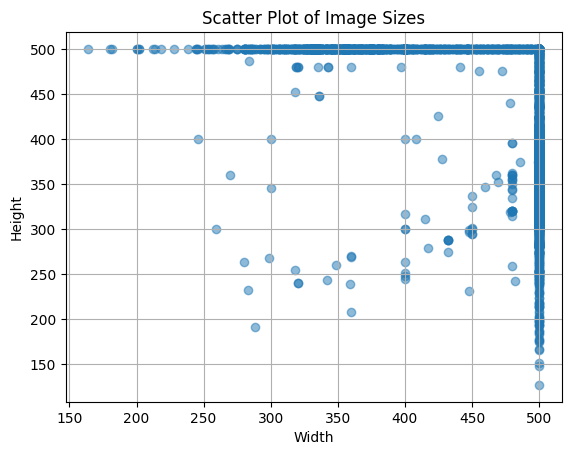

In [4]:
get_descriptive_statistics(image_folder)

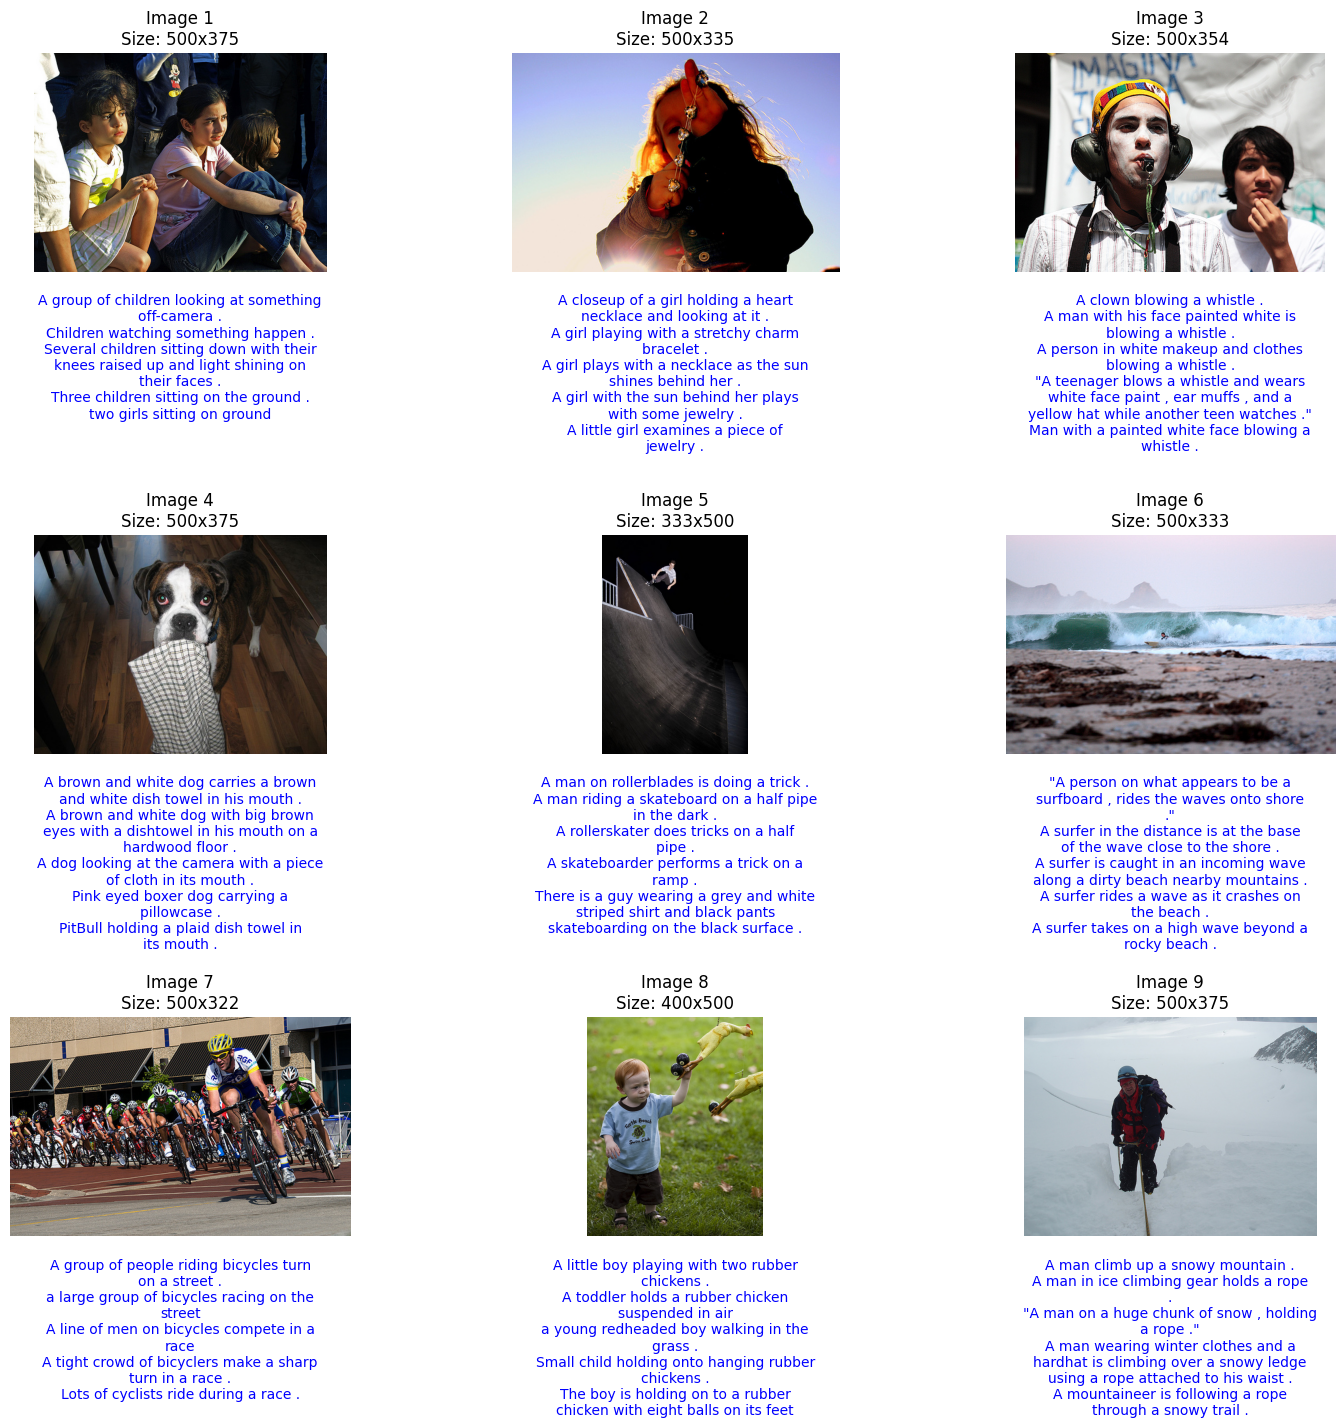

In [5]:
explore_dataset(image_folder, captions_file)

___
## Loading the Data

In [6]:
image_arrays, image_captions = load_data(image_folder_homogeneous, captions_file)

In [7]:
print(type(image_arrays), type(image_captions))

<class 'dict'> <class 'dict'>


### Cleaning the Captions

We exploring the `data/captions.txt` file, we notice that the captions seem to end with a `.`, so let's just remove this to have cleaner captions.

In [8]:
image_captions = {
    img_name: [cap.replace('.', '').strip().lower() for cap in captions]
    for img_name, captions in image_captions.items()
}

### Creating the Vocabulary

The vocabulary contains all the unique words present in the captions.

In [9]:
vocabulary = get_vocabulary(image_captions)

___
## Splitting the Dataset

In [10]:
train_data, val_data, test_data, train_captions, val_captions, test_captions = split_and_save_data(image_arrays, image_captions, save_folderpath=split_data)

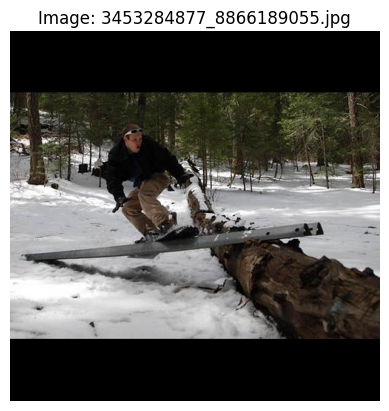

['a guy is grinding a rail over a tree on his snowboard', 'a man snowboarding making a jump off a steel guardrail', 'a snowboarder grinding up a homemade ramp', 'a snowboarder is riding his board on ramp made from a piece of metal and a log', 'the man is skateboarding over a log in the snow']


In [11]:
i = 129
visualize_image(train_data, i)
print(
    get_captions(train_captions, i)
)

___
## Extracting a Feature Vector from each image

We can extract the main features of an image with a pre-trained model, which has been trained in a large dataset. This way we can get from each image a vector containing the main characteristics of this image. We will use the **InceptionV3** model.

In [ ]:
def get_ith_value(dict, i):
    return list(dict.values())[i]

In [23]:
base_model = InceptionV3(weights="imagenet")
model = Model(base_model.input, base_model.layers[-2].output)


def encode_images(img_dict: dict, model: Model = model) -> dict[str, np.ndarray]:
    print("resizing the images...")
    resized_images = resize_image_dictionary(img_dict, (299, 299))
    feature_vectors = {}
    print("extracting the feature vectors...")
    for img_name, img_arr in resized_images.items():
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = preprocess_input(img_arr)
        vec = model.predict(img_arr)
        vec = np.reshape(vec, (vec.shape[1]))
        feature_vectors[img_name] = vec
    return feature_vectors


fea_vec_train = encode_images(train_data)

print(fea_vec_train)

resizing the images...
extracting the feature vectors...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━